<a href="https://colab.research.google.com/github/yanirasilva-star/ICD/blob/main/Data_Lead_TG1_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introducción A Ciencia De Datos Y Machine Learning Con Python**

**Integrantes:**



*   Arizaba Garcia Topacio

*   Silva Ruiz Yanira
*   Vega castro Angie


*   Vazquez Milian Andy


**Profesor:** Luis Jose Zapata Bobadilla

**Universidad de Piura**

# **Pregunta**: *¿Cuál es la influencia de la tasa de interés de referencia en la dinámica de la inflación en el corto plazo en el Perú?* 📈
___

## **Información antes de la limpieza**

### **1. Definición del periodo y variables**

 **PERIÓDO**
* Periodo inicial: **Enero del 2010**
* Periodo final: **Agosto del 2025**

**VARIABLES**
1. PN38705PM: Inflación mensual (variación % IPC)
2. PD04722MM: Tasa de interés de referencia (TIR)
3. PN07819NM: Tasa de interés interbancaria promedio
4.  PN06522TM: repo de valores saldo
5. PN06534TM: depósitos públicos saldo
6. PN06502OM: CD BCRP - Total - Saldo
7. PN06503OM: CD BCRP - Tasa de ínteres - Saldo
8. PN07150NM: Depositos overnight BCRP (promedio diario) - Empresas Bancarias (miles S/)
9. PD04724MM: Tasa de los Depósitos Overnight en MN

Entre ellas, la inflación (IPC) y la tasa de referencia son las variables principales.
Las demás funcionan como canales de transmisión (tasa interbancaria, depósitos overnight) o instrumentos operativos (repos, CDBCR, depósitos).



**Librerias**
  `pandas`, `numpy`y `requests` para hacer petición a la web.

**Formato:**  se usa `json  `,es la manera más práctica y estándar de recibir la información y convertirla en objetos de Python para trabajar con ellos.

Realiza una solicitud GET a la API de BCRP utilizando `requests.get()`
Comprueba si la solicitud fue exitosa (código de estado 200).
Si la operación es correcta, analiza la respuesta JSON en un diccionario de Python y la almacena en la datavariable. De lo contrario, muestra un mensaje de error.





---



In [ ]:
# Primero, importamos las librerías que necesitaremos
import requests  # La librería estándar en Python para hacer peticiones a la web
import pandas as pd
import numpy as np

# 1. Definimos los parámetros de nuestra consulta
codigos = 'PN38705PM-PD04722MM-PN07819NM-PN06522TM-PN06534TM-PN06502OM-PN06503OM-PN07150NM-PD04724MM'
formato = 'json' # Pedimos los datos en formato JSON
periodo_inicial = '2010-01'
periodo_final = '2025-08'

# 2. Construimos la URL completa
url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codigos}/{formato}/{periodo_inicial}/{periodo_final}"

# 3. Hacemos la petición GET a la web del BCRP
response = requests.get(url)

# 4. Verificamos que la petición fue exitosa (un código 200 significa que todo salió bien)
if response.status_code == 200:
    print("¡Conexión exitosa con el API del BCRP!")
    # Convertimos la respuesta a un formato de diccionario de Python
    data = response.json()
else:
    print(f"Error al conectar con el API. Código de estado: {response.status_code}")
    data = None

¡Conexión exitosa con el API del BCRP!


### **2.Inspección de la estructura de datos sin procesar:**

Antes de convertir los datos a un formato estructurado como un DataFrame de Pandas, inspeccionamos los datos sin procesar recibidos de la API de BCRP para comprender su organización. Esto se realizó imprimiendo las dos primeras y la última entrada de la  lista "periods"  dentro del  objeto "data"  . Esto nos permitió ver:

*    El formato de la información de fecha (que  más tarde se convertiría en la  columna **'Fecha'**  en nuestro DataFrame).
*  Cómo se almacenan   los valores de cada variable (que más tarde llenarían columnas como  **'Tasa\_Ref (%)'** ,  **'IPC (%)'** , etc.) en una lista para cada período.
*    El orden en que aparecen estos valores de variable  en la lista para cada período, lo cual fue crucial para  extraer y etiquetar correctamente los datos en las columnas apropiadas del DataFrame.

Este paso confirmó que los datos están estructurados como  una lista de períodos, donde cada período contiene una fecha y una lista de valores de variables correspondientes en  un orden consistente, preparándonos para crear nuestro DataFrame estructurado.

In [ ]:
# Miremos los datos de los primeros dos periodos para entender la estructura
# [tasa de interés de ref, tasa de depósitos overnight, CDBCR total saldo, CDBCR saldo tasa de interés, repos de valores, depósitos públicos, depósitos overnight BCR,  tasa de interés interbancaria, IPC]
if data:
    print(data['periods'][0])
    print(data['periods'][1])
    print(data['periods'][-1])

{'name': 'Ene.2010', 'values': ['1.25', '0.45', '19352.2', '1.48499168053245', '0', '0', 'n.d.', '1', '69.7136816328321']}
{'name': 'Feb.2010', 'values': ['1.25', '0.45', '20057.9', '1.48248012005245', '0', '0', 'n.d.', '1.21524', '69.9385138944542']}
{'name': 'Ago.2025', 'values': ['4.5', '2.5', '43991.9', '4.2065169497112', '7306.947803', '4024.9', '78929.5483870968', '4.5079', '115.586828']}


### **3. Estructuración de los datos en un DataFrame:**

Este bloque de código se centra en convertir los datos sin procesar , en formato de lista de diccionarios, en  un DataFrame estructurado de Pandas.

Así es como funciona:

* **Inicialización de listas:**  Se crean listas vacías para cada variable (p. ej.,  `fechas` ,  `tir` ,  `ipc` ) para almacenar temporalmente los datos extraídos.  
*  **Iteración por períodos:**  El código recorre cada  `period`  en la  lista `data['periods']`  obtenida de la API de BCRP.  
*  **Extracción de datos:**  Dentro del bucle:  
    *  Se extrae    la fecha ( `period['name']` ) y se agrega a la  lista `fechas` .
    *  Se extrae   la lista de valores de todas las variables ( `period['values']` ).
    *    Para cada variable, se accede al valor correspondiente desde la  lista `valores`  usando su índice (según el orden de los códigos  en la llamada a la API).
    *    El valor extraído se convierte a un  `float`  si es un número válido. Si el valor es 'nd' (que indica no disponible), se reemplaza con  `np.nan`  (no es un número) para representar los datos faltantes en el DataFrame .
    *    Estos valores procesados ​​se añaden a sus respectivas listas.
*  **Creación del DataFrame:**  Después de procesar todos los períodos,   se crea un diccionario `datos_para_df` . Las claves de este diccionario son los nombres de columna deseados para el DataFrame (por ejemplo, 'Fech a', 'Tasa\_Ref (%)'), y los valores son las listas  que contienen los datos extraídos y procesados ​​para cada variable.  
*  **Relleno del DataFrame:** Finalmente,  se crea   un DataFrame de pandas  `df_bcrp` a partir del diccionario `datos_para_df`  . La  línea `display(df_bcrp.head())`  muestra las primeras filas del DataFrame recién creado, lo que permite una rápida verificación de  la estructura y los datos.

Este proceso transforma eficazmente los datos sin procesar de la API en un formato tabular limpio, listo para su posterior análisis y visualización en los  pasos posteriores.

In [ ]:
if data:
    # Creamos listas vacías
    fechas = []
    tir = []
    tover = []
    cdbcr_total = []
    cdbcr_tir = []
    repos_valores = []
    depositos_publicos = []
    depositos_overnight = []
    interbancaria = []
    ipc = []


    # Iteramos sobre los periodos en los datos del BCRP
    for periodo in data['periods']:
        fechas.append(periodo['name'])

        # Los valores vienen en el mismo orden en que pusiste los códigos en la URL:
        # PN38705PM - PD04722MM - PN07839NM - PN06525TM - PN06534TM
        valores = periodo['values']

        # Tasa de interés de referencia
        tir.append(float(valores[0]) if valores[0] != 'n.d.' else np.nan)
        # Depositos overnight
        tover.append(float(valores[1]) if valores[1] != 'n.d.' else np.nan)
        # CDBCR total saldo
        cdbcr_total.append(float(valores[2]) if valores[2] != 'n.d.' else np.nan)
        # CDBCR saldo tasa de interés
        cdbcr_tir.append(float(valores[3]) if valores[3] != 'n.d.' else np.nan)
       # Repos (saldo)
        repos_valores.append(float(valores[4]) if valores[4] != 'n.d.' else np.nan)
       # Depósitos públicos (saldo)
        depositos_publicos.append(float(valores[5]) if valores[5] != 'n.d.' else np.nan)
        # Depositos overnight BCR
        depositos_overnight.append(float(valores[6]) if valores[6] != 'n.d.' else np.nan)
        # Tasa interbancaria promedio
        interbancaria.append(float(valores[7]) if valores[7] != 'n.d.' else np.nan)
        # IPC (variación %)
        ipc.append(float(valores[8]) if valores[8] != 'n.d.' else np.nan)

            # Construimos el DataFrame
    datos_para_df = {
        'Fecha': fechas,
        'Tasa_Ref (%)': tir,
        'Tasa_Depositos_Overnight (%)': tover,
        'CDBCR_Total_Saldo (S/ millones)': cdbcr_total,
        'CDBCR_Saldo_TIR (%)': cdbcr_tir,
        'Repos_Valores (S/ millones)': repos_valores,
        'Depositos_Publicos_Saldo (S/ millones)': depositos_publicos,
        'Depositos_Overnight_BCR (S/ miles)': depositos_overnight,
        'Tasa_Interbancaria (%)': interbancaria,
        'IPC (%)': ipc,

    }

    df_bcrp = pd.DataFrame(datos_para_df)

    print("DataFrame creado exitosamente:")
    display(df_bcrp.head())
else:
    print("No se pudieron cargar los datos para crear el DataFrame.")


DataFrame creado exitosamente:


,Fecha,Tasa_Ref (%),Tasa_Depositos_Overnight (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%),IPC (%)
0,Ene.2010,1.25,0.45,19352.2,1.484992,0.0,0.0,NaN,1.00000,69.713682
1,Feb.2010,1.25,0.45,20057.9,1.482480,0.0,0.0,NaN,1.21524,69.938514
2,Mar.2010,1.25,0.45,21752.6,1.496076,0.0,0.0,NaN,1.23264,70.134910
3,Abr.2010,1.25,0.45,19070.7,1.438794,0.0,0.0,NaN,1.21970,70.152694
4,May.2010,1.50,0.70,17733.4,1.356306,0.0,0.0,NaN,1.44610,70.319559


###**4. Información descriptiva de la data**

In [ ]:
df_bcrp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Fecha                                   188 non-null    object 
 1   Tasa_Ref (%)                            188 non-null    float64
 2   Tasa_Depositos_Overnight (%)            188 non-null    float64
 3   CDBCR_Total_Saldo (S/ millones)         188 non-null    float64
 4   CDBCR_Saldo_TIR (%)                     188 non-null    float64
 5   Repos_Valores (S/ millones)             188 non-null    float64
 6   Depositos_Publicos_Saldo (S/ millones)  188 non-null    float64
 7   Depositos_Overnight_BCR (S/ miles)      173 non-null    float64
 8   Tasa_Interbancaria (%)                  188 non-null    float64
 9   IPC (%)                                 188 non-null    float64
dtypes: float64(9), object(1)
memory usage: 14.8+ KB


In [ ]:
df_bcrp.describe()

,Tasa_Ref (%),Tasa_Depositos_Overnight (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%),IPC (%)
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,1.730000e+02,188.000000,188.000000
mean,3.731383,2.518085,31602.873936,3.764552,4502.582211,2265.238298,7.373671e+05,3.747771,90.084022
std,1.806753,1.305026,13886.277523,1.662738,4497.319051,2239.238064,1.201505e+06,1.816596,13.674008
min,0.250000,0.150000,12757.200000,0.364835,0.000000,0.000000,1.910300e+04,0.110600,69.713682
25%,2.750000,1.500000,20975.000000,2.800000,0.000000,0.000000,2.008710e+05,2.752650,78.497451
50%,4.000000,2.750000,28635.050000,3.895000,3217.000000,1904.000000,3.785680e+05,4.000950,88.756454
75%,4.250000,3.450000,38553.075000,4.539318,7744.683148,4100.100000,7.480710e+05,4.368450,98.438826
max,7.750000,5.250000,81435.000000,7.571590,15654.446000,7044.400000,8.106778e+06,7.761200,115.923300


 **Información General:**

 Los principales hallazgos del análisis, basado en las funciones `df_bcrp.info()` y `df_bcrp.describe().`

El DataFrame contiene 173 observaciones y 10 columnas.

**Estadísticas Descriptivas Clave:**

* **Tasa de Referencia (Tasa_Ref %):** Muestra variabilidad esperada con un rango de 0.25% a 7.75% (media de 3.83%), reflejando ajustes de política monetaria.

* **IPC (%)**: Presenta un rango amplio (70.95% a 115.92%, media de 91.68%) con una desviación estándar notable (13.06), indicando fluctuaciones en la inflación, incluyendo picos.

* **Canales de Transmisión e Instrumentos Operativos:** Tasas como la interbancaria y de depósitos overnight, así como los saldos de repos y CDBCR, exhiben mayor volatilidad y rangos amplios, especialmente durante períodos de crisis, lo que sugiere su uso activo por parte del BCRP.
Correlaciones: Existe una alta correlación entre la Tasa de Referencia y otras tasas de interés (interbancaria, depósitos overnight, y TIR de CDBCR), confirmando su rol en la transmisión de la política monetaria. La correlación positiva entre Repos y el IPC podría indicar el uso de liquidez en respuesta a presiones inflacionarias o viceversa.
Conclusión:

El análisis descriptivo revela que el DataFrame ``df_bcrp contiene información relevante sobre la política monetaria y la inflación en Perú.

###**5.Limpieza de data**

**5.1 Eliminar datos faltanes:**
Este bloque de código se encarga de la limpieza de datos, específicamente eliminando filas que contienen valores faltantes (NaN) en cualquier columna del DataFrame `df_bcrp`.


* `df_bcrp.dropna(inplace=True)`Esta línea elimina cualquier fila del DataFrame df_bcrpque contenga al menos un valor faltante ( NaN).
* `El inplace=True`Modifica el DataFrame directamente sin crear uno nuevo.
`df_bcrp.info()`:Esta línea muestra luego un resumen conciso del DataFrame modificado.
El resultado `df_bcrp.info()`después de la ejecución `dropna()`muestra la estructura del DataFrame, incluyendo el número de entradas (filas) y el recuento de valores no nulos en cada columna. Si el número de entradas es menor que el original (que era 188 antes de este paso, como se muestra en el resultado del paso anterior `df_bcrp.info()`), significa que se eliminaron correctamente algunas filas con valores faltantes.






In [ ]:
# Eliminar las filas con valores faltantes en cualquier columna
df_bcrp.dropna(inplace=True)

# Verificar nuevamente el estado del DataFrame
df_bcrp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 11 to 187
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Fecha                                   173 non-null    object 
 1   Tasa_Ref (%)                            173 non-null    float64
 2   Tasa_Depositos_Overnight (%)            173 non-null    float64
 3   CDBCR_Total_Saldo (S/ millones)         173 non-null    float64
 4   CDBCR_Saldo_TIR (%)                     173 non-null    float64
 5   Repos_Valores (S/ millones)             173 non-null    float64
 6   Depositos_Publicos_Saldo (S/ millones)  173 non-null    float64
 7   Depositos_Overnight_BCR (S/ miles)      173 non-null    float64
 8   Tasa_Interbancaria (%)                  173 non-null    float64
 9   IPC (%)                                 173 non-null    float64
dtypes: float64(9), object(1)
memory usage: 14.9+ KB


2.2 Columnas irrelevantes

In [ ]:
df_bcrp.describe()

,Tasa_Ref (%),Tasa_Depositos_Overnight (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%),IPC (%)
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,1.730000e+02,173.000000,173.000000
mean,3.830925,2.581792,32352.843931,3.866986,4892.979512,2461.646243,7.373671e+05,3.855318,91.683913
std,1.817217,1.295610,14181.308983,1.662927,4479.782535,2228.266819,1.201505e+06,1.820581,13.063218
min,0.250000,0.150000,12757.200000,0.364835,0.000000,0.000000,1.910300e+04,0.110600,70.951291
25%,2.750000,1.500000,23445.800000,3.000000,800.000000,0.000000,2.008710e+05,2.784900,80.929225
50%,4.000000,2.750000,29466.000000,3.940000,4383.299619,2100.000000,3.785680e+05,4.074600,89.440878
75%,4.250000,3.450000,39269.800000,4.600000,8185.646000,4100.200000,7.480710e+05,4.464100,100.037268
max,7.750000,5.250000,81435.000000,7.571590,15654.446000,7044.400000,8.106778e+06,7.761200,115.923300


2.3 Filas repetidas

In [ ]:
# Ver las filas duplicadas
duplicadas = df_bcrp[df_bcrp.duplicated()]
print(duplicadas)

Empty DataFrame
Columns: [Fecha, Tasa_Ref (%), Tasa_Depositos_Overnight (%), CDBCR_Total_Saldo (S/ millones), CDBCR_Saldo_TIR (%), Repos_Valores (S/ millones), Depositos_Publicos_Saldo (S/ millones), Depositos_Overnight_BCR (S/ miles), Tasa_Interbancaria (%), IPC (%)]
Index: []


### **6. Detección de Posibles Outliers**

Este bloque de código tiene como objetivo **identificar posibles valores atípicos (outliers)** en las columnas numéricas del DataFrame `df_bcrp` utilizando el método del **Rango Intercuartílico (IQR)**.

- **`columnas_numericas = df_bcrp.select_dtypes(include=['float64', 'int64'])`**  
  Selecciona solo las columnas numéricas (`float64` o `int64`) del DataFrame `df_bcrp` y las guarda en `columnas_numericas`.  
  Esto es necesario porque el cálculo de outliers basado en IQR solo es aplicable a datos numéricos.

- **`Q1 = columnas_numericas.quantile(0.25)`**  
  Calcula el **primer cuartil (Q1)** para cada columna numérica.  
  El Q1 representa el valor por debajo del cual se encuentra el 25 % de los datos.

- **`Q3 = columnas_numericas.quantile(0.75)`**  
  Calcula el **tercer cuartil (Q3)** para cada columna numérica.  
  El Q3 representa el valor por debajo del cual se encuentra el 75 % de los datos.

- **`IQR = Q3 - Q1`**  
  Calcula el **Rango Intercuartílico (IQR)**, que es la diferencia entre Q3 y Q1.  
  El IQR mide la dispersión de la mitad central de los datos.

- **`outliers = ((columnas_numericas < (Q1 - 1.5 * IQR)) | (columnas_numericas > (Q3 + 1.5 * IQR))).sum()`**  
  Detecta los posibles outliers.  
  Se considera un rango "normal" para los datos: `[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]`.  
  Cualquier valor fuera de este rango se considera un posible outlier.  
  La expresión genera un DataFrame con `True` donde hay un outlier y `False` en caso contrario.  
  El `.sum()` cuenta la cantidad de `True` en cada columna (cantidad de outliers).


In [ ]:
# Seleccionar solo las columnas numéricas
columnas_numericas = df_bcrp.select_dtypes(include=['float64', 'int64'])

# Calcular el IQR solo para las columnas numéricas
Q1 = columnas_numericas.quantile(0.25)
Q3 = columnas_numericas.quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers
outliers = ((columnas_numericas < (Q1 - 1.5 * IQR)) | (columnas_numericas > (Q3 + 1.5 * IQR))).sum()

# Mostrar el conteo de outliers por variable
print("Cantidad de posibles outliers por variable:")
print(outliers)



Cantidad de posibles outliers por variable:
Tasa_Ref (%)                              32
Tasa_Depositos_Overnight (%)               0
CDBCR_Total_Saldo (S/ millones)           11
CDBCR_Saldo_TIR (%)                       20
Repos_Valores (S/ millones)                0
Depositos_Publicos_Saldo (S/ millones)     0
Depositos_Overnight_BCR (S/ miles)        19
Tasa_Interbancaria (%)                    28
IPC (%)                                    0
dtype: int64


### **7. Graficos**

### **7.1 Boxplots**



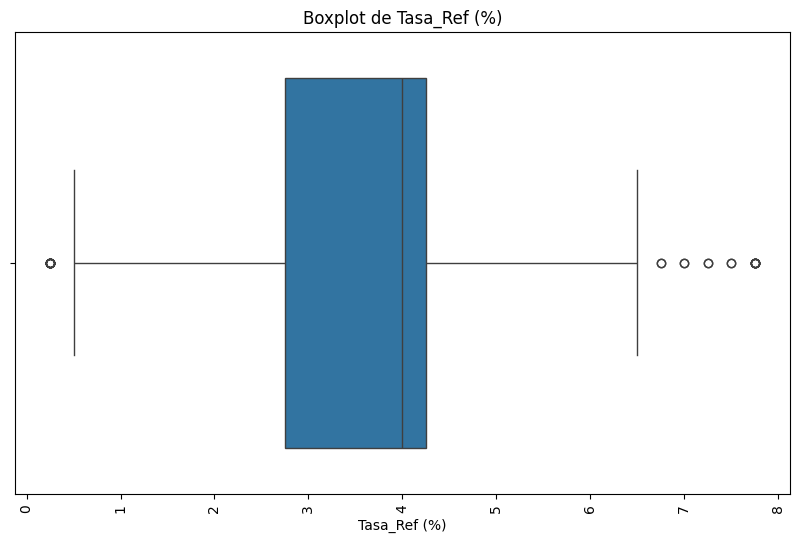

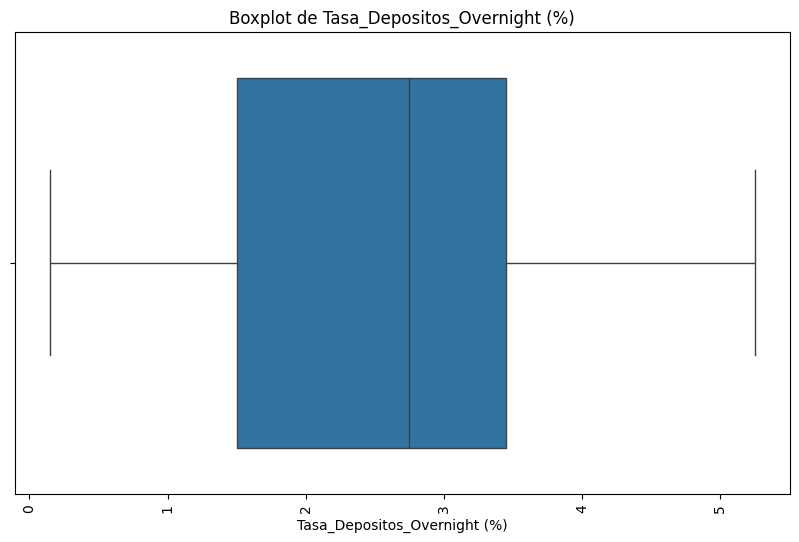

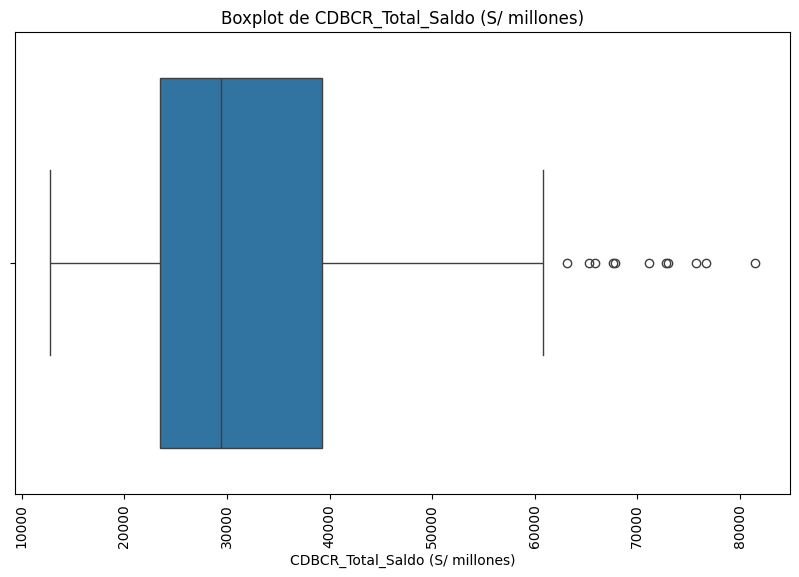

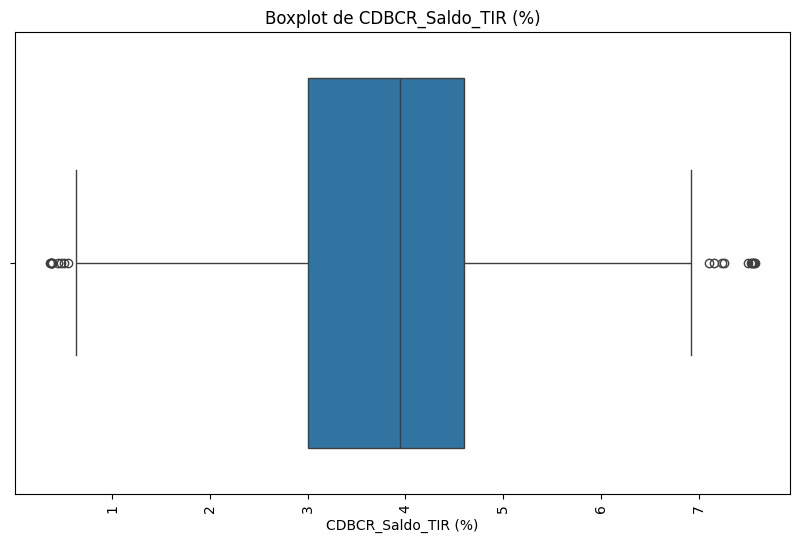

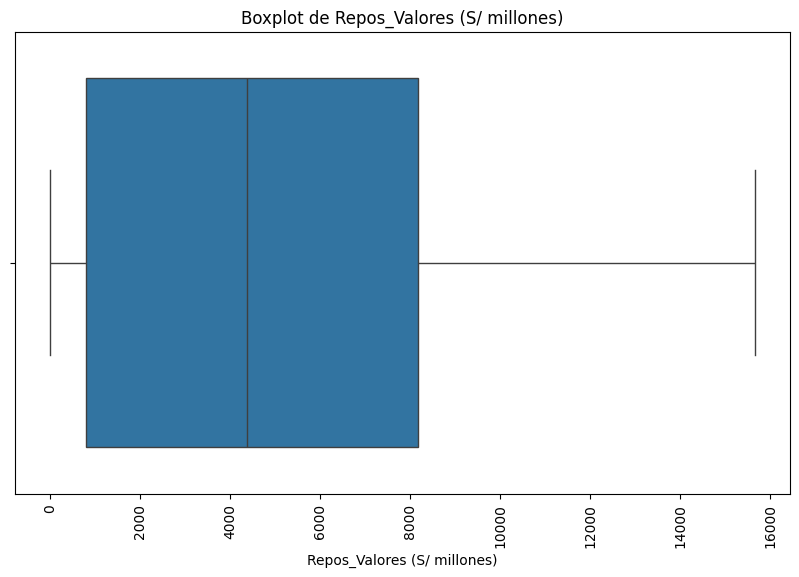

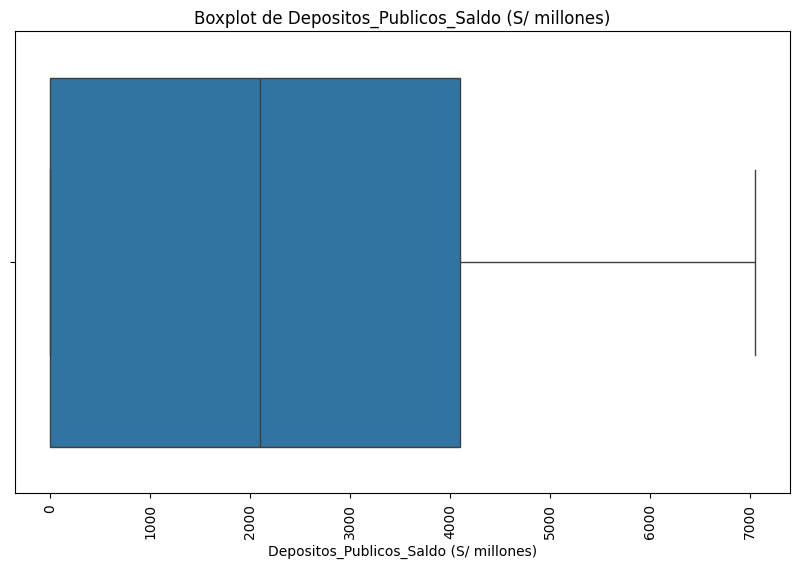

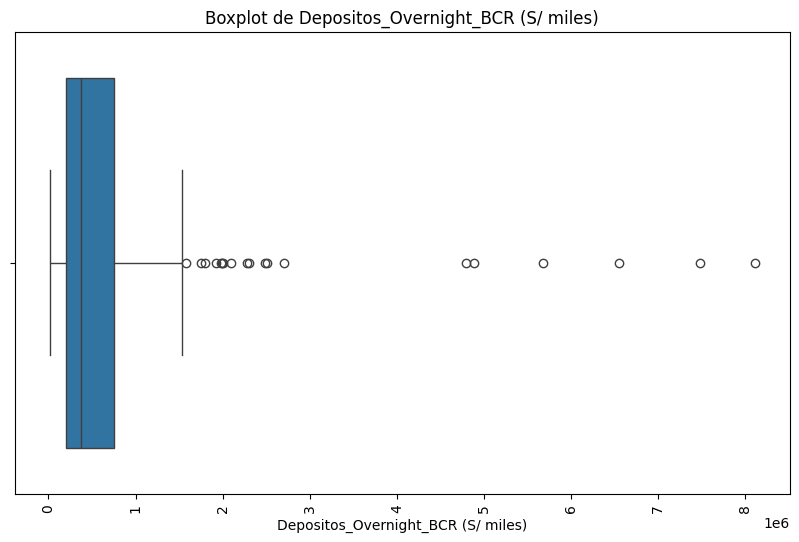

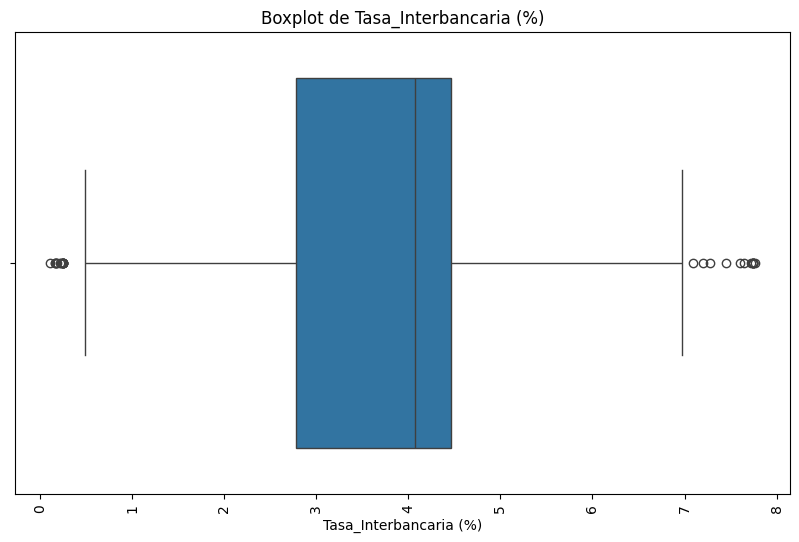

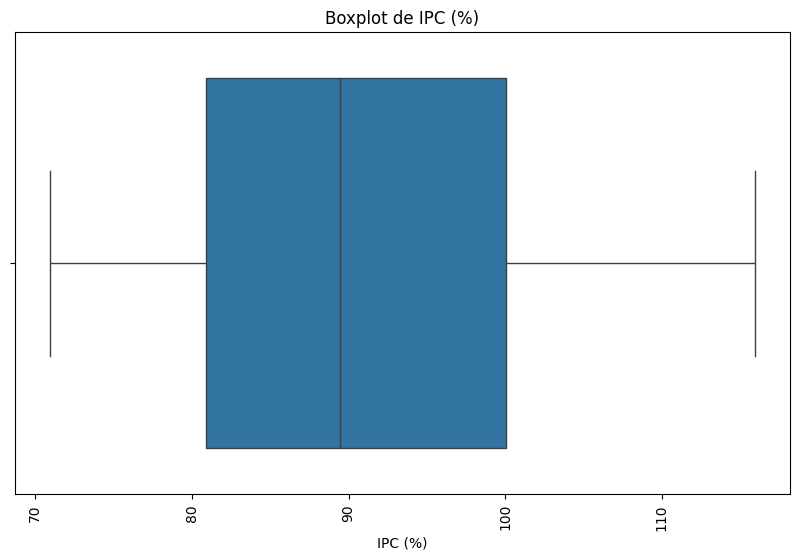

In [ ]:
 import seaborn as sns
import matplotlib.pyplot as plt

# Definir las columnas numéricas de interés
variables = columnas_numericas.columns

# Crear un boxplot por cada variable
for var in variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_bcrp[var])
    plt.title(f'Boxplot de {var}')
    plt.xticks(rotation=90)  # Rotar las etiquetas del eje X para mejor visibilidad
    plt.show()

**Interpretación:**

Estos gráficos nos ayudan a entender la distribución de los datos de cada variable. Cada caja representa el 50% de los valores centrales, la línea en el medio es la mediana, y las líneas que se extienden (bigotes) muestran el rango general de los datos.

En los gráficos de las tasas de interés (Tasa_Ref, Tasa_Interbancaria y Tasa_Depositos_Overnight), las cajas son muy estrechas. Esto significa que los valores de estas tasas no varían mucho, lo cual es normal porque el Banco Central las controla. Los puntos que ves fuera de los "bigotes" son valores atípicos, que pueden representar momentos de cambios abruptos en la política monetaria.

En el gráfico de la inflación (IPC), la caja es más ancha, mostrando que este indicador es más volátil que las tasas de interés. Aun así, la mayoría de los datos se agrupan de forma predecible sin tener valores extremadamente altos o bajos.

Finalmente, los gráficos de los saldos (CDBCR_Total_Saldo, Repos_Valores y Depósitos_Públicos_Saldo) tienen cajas muy pequeñas, pero con muchos puntos dispersos por encima. Esto nos dice que, aunque la mayoría de los valores son bajos, hay ocasiones en las que se registran transacciones o saldos excepcionalmente grandes. Estos valores atípicos son comunes en los mercados financieros, ya que reflejan operaciones extraordinarias de gran escala que ocurren con poca frecuencia.

## **Información despues de la limpieza**

In [ ]:
df_bcrp.describe()

,Tasa_Ref (%),Tasa_Depositos_Overnight (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%),IPC (%)
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,1.730000e+02,173.000000,173.000000
mean,3.830925,2.581792,32352.843931,3.866986,4892.979512,2461.646243,7.373671e+05,3.855318,91.683913
std,1.817217,1.295610,14181.308983,1.662927,4479.782535,2228.266819,1.201505e+06,1.820581,13.063218
min,0.250000,0.150000,12757.200000,0.364835,0.000000,0.000000,1.910300e+04,0.110600,70.951291
25%,2.750000,1.500000,23445.800000,3.000000,800.000000,0.000000,2.008710e+05,2.784900,80.929225
50%,4.000000,2.750000,29466.000000,3.940000,4383.299619,2100.000000,3.785680e+05,4.074600,89.440878
75%,4.250000,3.450000,39269.800000,4.600000,8185.646000,4100.200000,7.480710e+05,4.464100,100.037268
max,7.750000,5.250000,81435.000000,7.571590,15654.446000,7044.400000,8.106778e+06,7.761200,115.923300


### **1.TENDENCIAS**

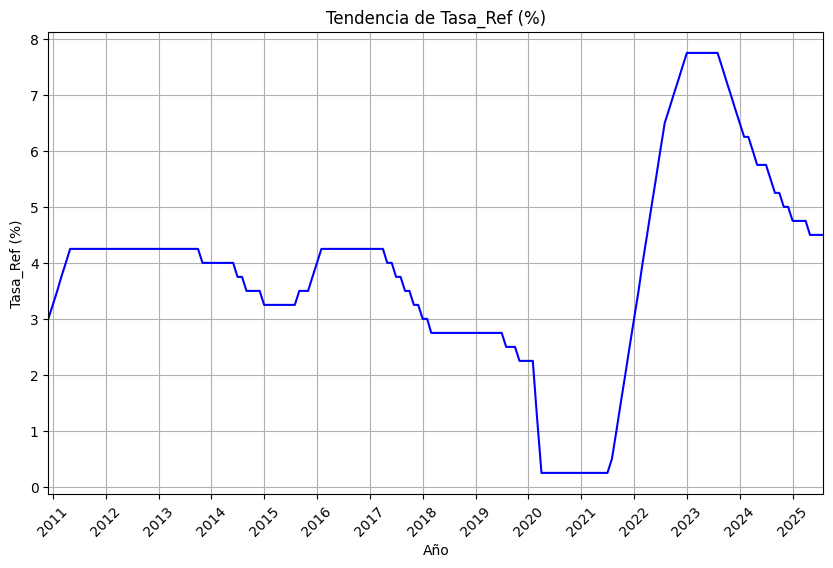

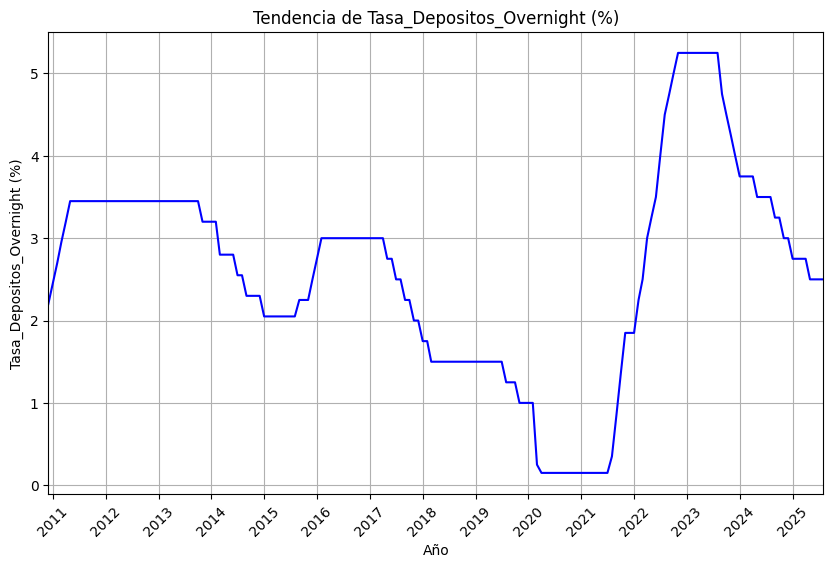

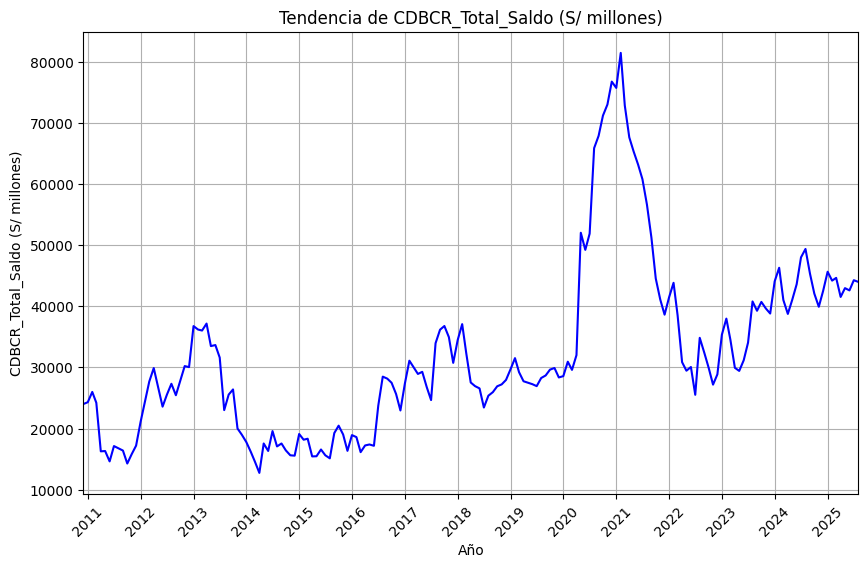

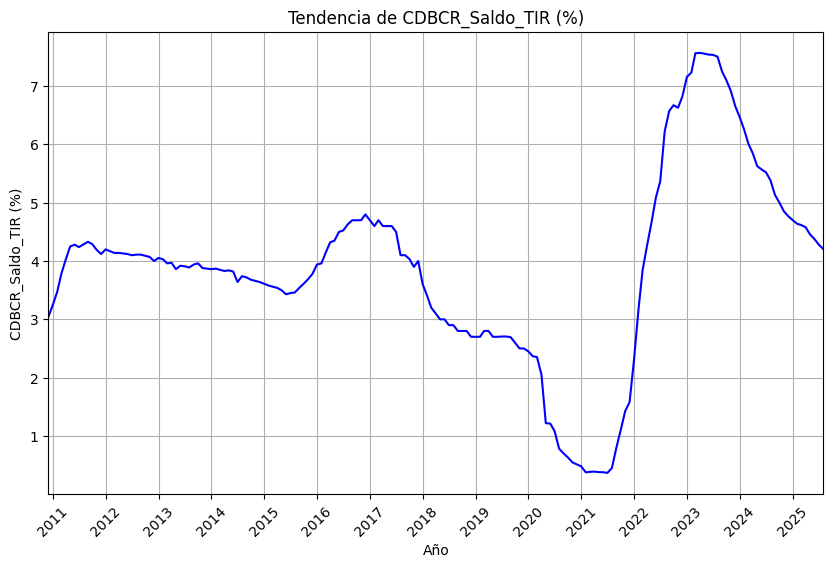

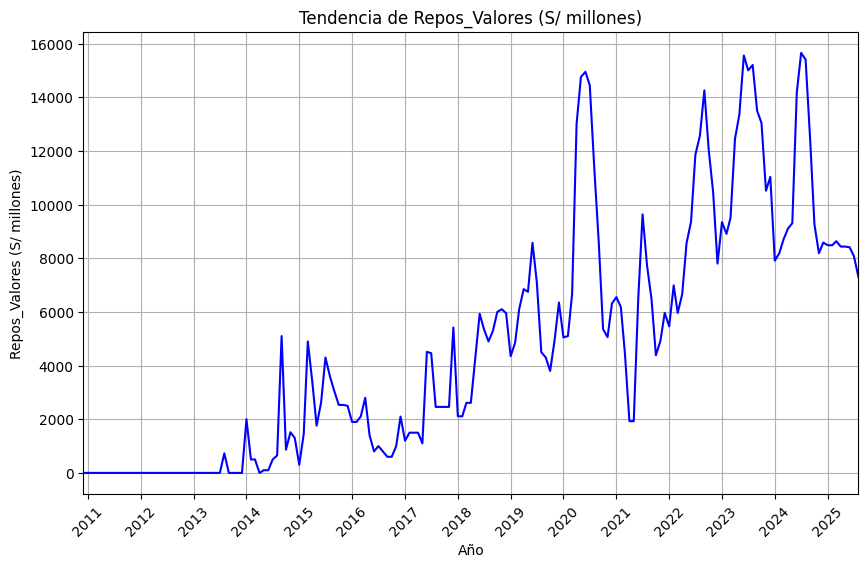

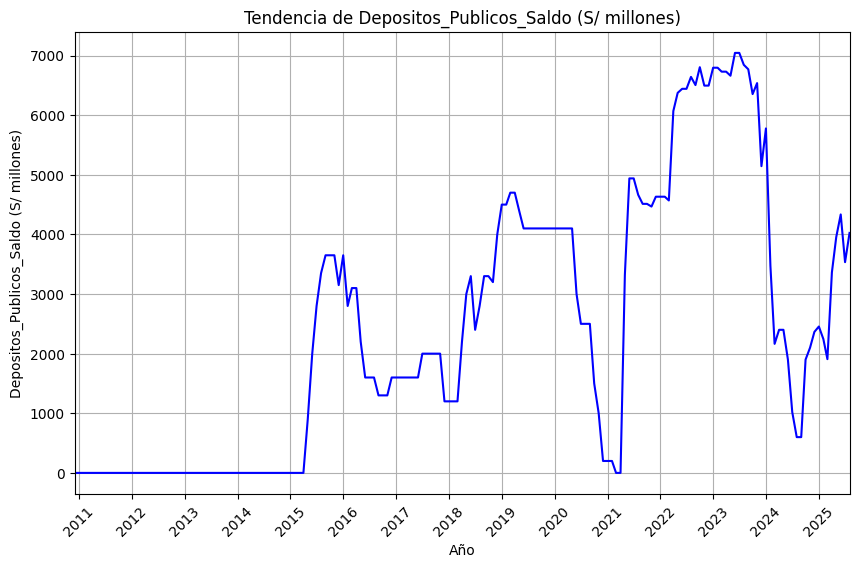

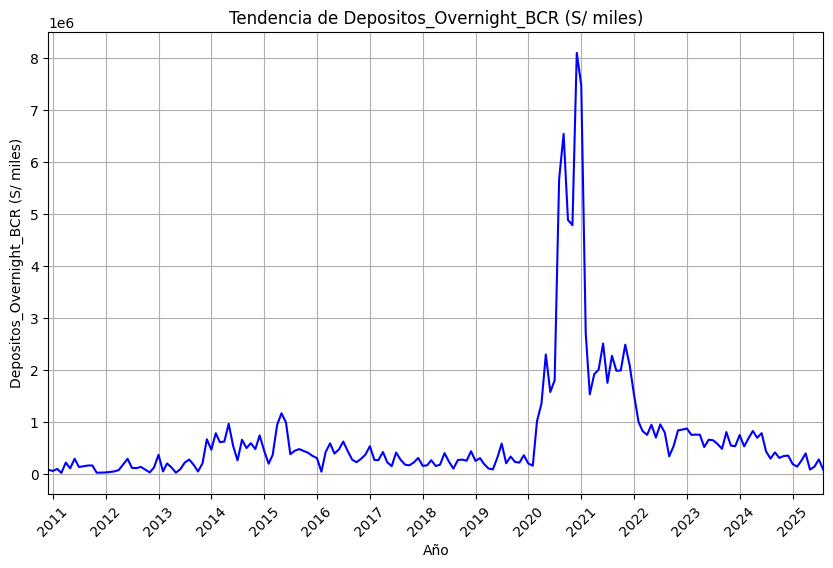

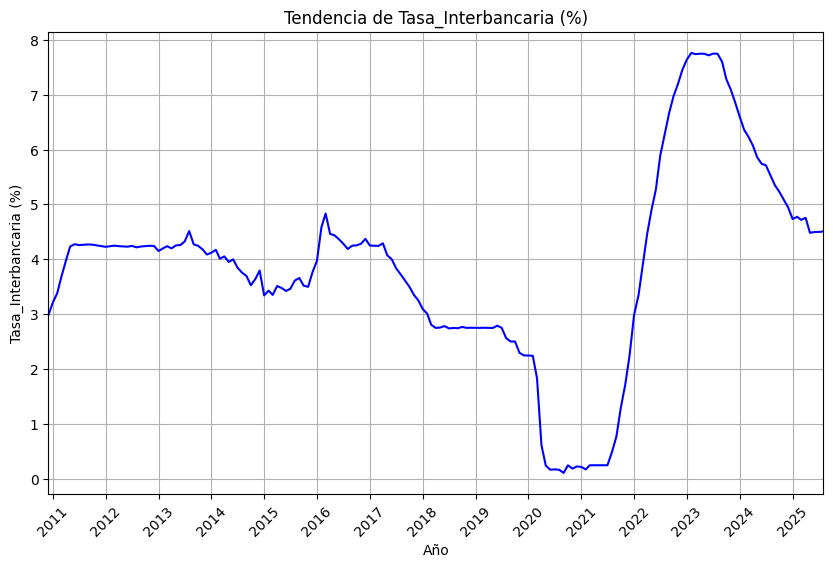

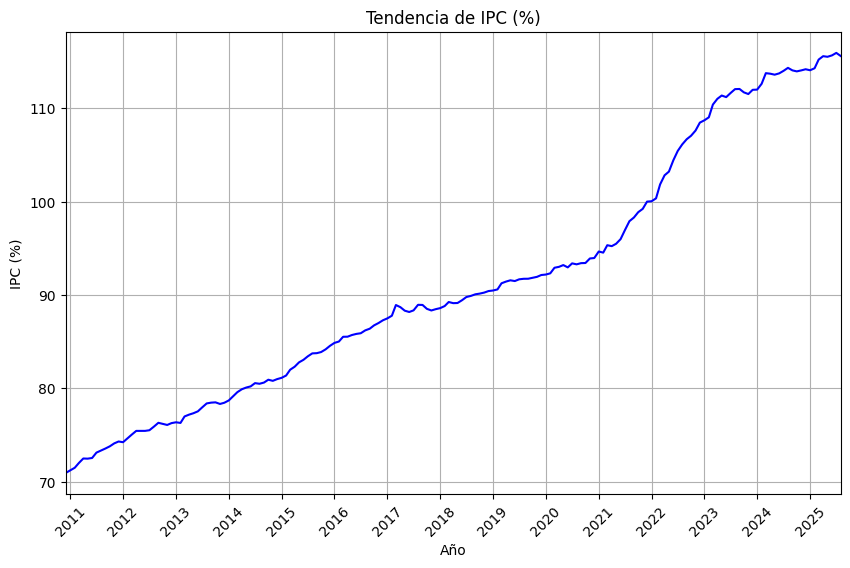

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Crear un diccionario para mapear los meses en español al formato en inglés
meses_esp = {
    'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'May': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Ago': 'Aug', 'Sep': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'
}

# Función para convertir las fechas en español al formato inglés
def convertir_mes(fecha):
    mes, año = fecha.split('.')
    mes = meses_esp[mes]  # Reemplazar el mes en español por su equivalente en inglés
    return f'{mes}.{año}'

# Aplicar la función a la columna 'Fecha'
df_bcrp['Fecha'] = df_bcrp['Fecha'].apply(convertir_mes)
df_bcrp['Fecha'] = pd.to_datetime(df_bcrp['Fecha'], format='%b.%Y')

# Definir las columnas numéricas de interés
variables = columnas_numericas.columns

# Obtener el rango de fechas del DataFrame
fecha_min = df_bcrp['Fecha'].min()
fecha_max = df_bcrp['Fecha'].max()

# Crear un gráfico de tendencias para cada variable
for var in variables:
    plt.figure(figsize=(10, 6))

    # Graficar solo la línea, sin puntos
    plt.plot(df_bcrp['Fecha'], df_bcrp[var], linestyle='-', color='b')

    # Configurar el formato del eje X para mostrar solo el año
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Mostrar todos los años del rango de datos
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Mostrar todos los años

    # Limitar el rango del eje X al mínimo y máximo de las fechas en el DataFrame
    plt.xlim([fecha_min, fecha_max])

    # Ajustes del gráfico
    plt.title(f'Tendencia de {var}')
    plt.xlabel('Año')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()



**Interpretación**

Las gráficas muestran varias tendencias en las variables del BCRP. La Tasa de Interés de Referencia, la Tasa de los Depósitos Overnight y la Tasa Interbancaria han exhibido movimientos similares a lo largo del tiempo, con picos de aumento notable. Estas tasas subieron abruptamente alrededor de finales de 2021 y se mantuvieron elevadas, alcanzando un pico en los últimos años del período analizado, lo que refleja una política monetaria más restrictiva para combatir la inflación.

La inflación (IPC) también muestra una tendencia ascendente general. Si bien presenta fluctuaciones, su valor ha aumentado significativamente, especialmente a partir de 2021. Este aumento coincide con la subida de las tasas de interés, lo que indica que el BCRP ha estado respondiendo de manera activa a las presiones inflacionarias.

Los saldos en S/ millones, como CDBCR_Total_Saldo y Repos_Valores, exhiben una variabilidad considerable. El saldo de los repos ha mostrado un crecimiento notable, lo que podría indicar una mayor intervención del BCRP en el mercado para proveer liquidez. Por otro lado, los Depósitos_Públicos_Saldo muestran picos altos ocasionales, lo que puede reflejar grandes movimientos de fondos del sector público en momentos específicos.

### **2. HISTOGRAMAS**

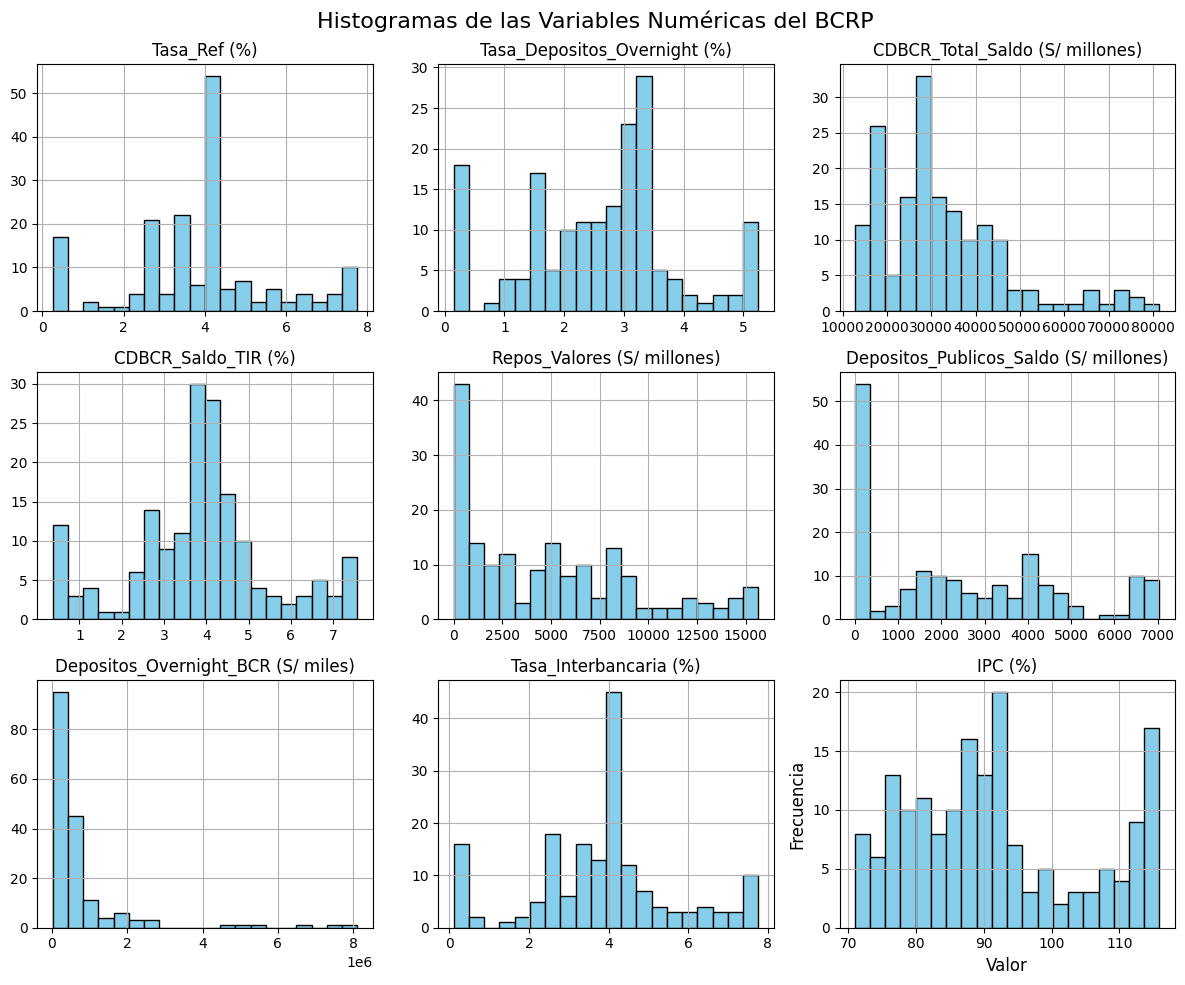

In [ ]:
import matplotlib.pyplot as plt

# Excluir la columna 'Fecha' del DataFrame para que no aparezca en el histograma
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Generar un histograma para cada variable numérica (sin la columna 'Fecha')
df_bcrp_sin_fecha.hist(bins=20, figsize=(12, 10), color='skyblue', edgecolor='black')

# Ajustar el título y las etiquetas
plt.suptitle('Histogramas de las Variables Numéricas del BCRP', fontsize=16)
plt.xlabel('Valor', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

**Interpretación:**

Los histogramas muestran que tanto la inflación (IPC) como la tasa de referencia del BCRP se concentran en valores bajos durante 2010-2019, reflejando estabilidad en precios y en la política monetaria. Sin embargo, a partir de 2020 ambos indicadores presentan colas hacia la derecha: la inflación se elevó por choques externos vinculados al COVID-19 y a la crisis internacional de alimentos y energía, y la tasa de referencia aumentó como respuesta. Esto confirma que, en el corto plazo, la tasa de referencia influye en la dinámica de la inflación, pues sus ajustes aparecen precisamente cuando los precios se desvían de la meta. Al mismo tiempo, los histogramas muestran la diferencia entre largos periodos de estabilidad (2010-2019) y episodios de crisis (2020-2022), lo que refleja que la política monetaria es efectiva en condiciones normales pero enfrenta limitaciones frente a shocks externos, explicando por qué la inflación no retorna de inmediato al rango meta pese al endurecimiento de la tasa. En conjunto, los resultados ilustran la influencia de la tasa de referencia sobre la inflación en el corto plazo, con efectos que se transmiten gradualmente y con ciertos rezagos.

### **3.MATRIZ DE CORRELACIÓN**

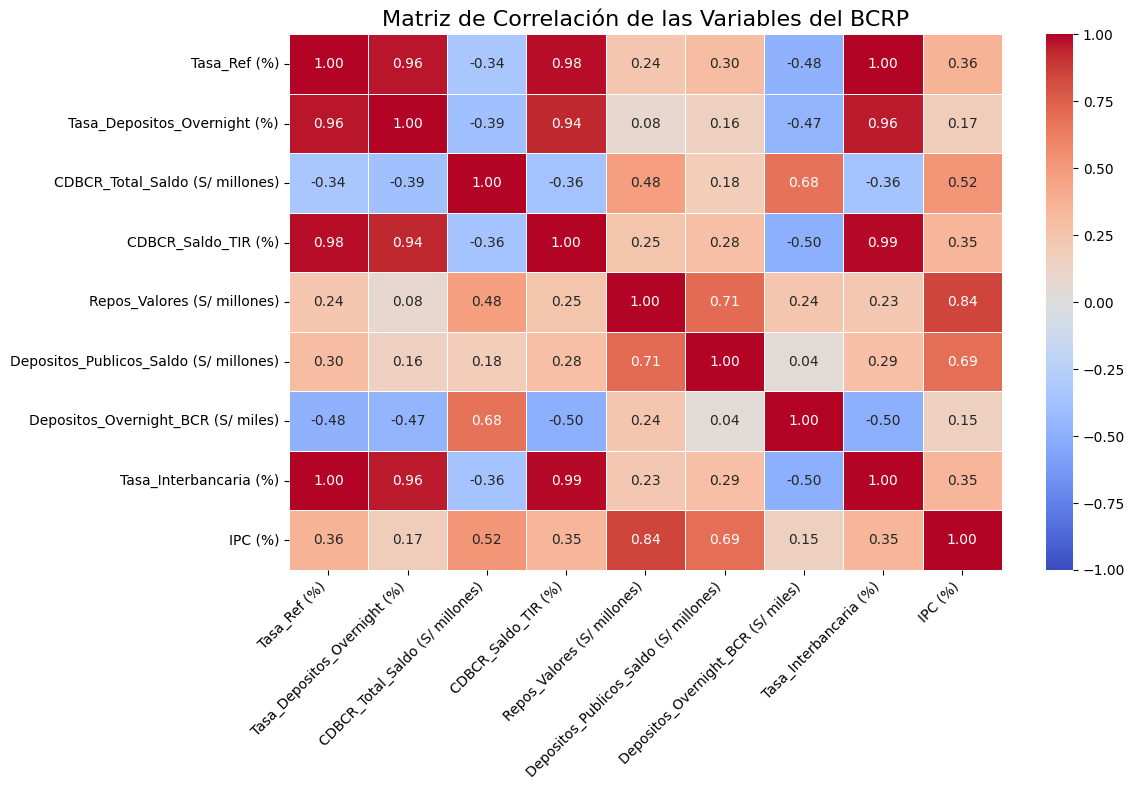

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Excluir la columna 'Fecha' para calcular la correlación solo con las variables numéricas
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Calcular la matriz de correlación
correlacion = df_bcrp_sin_fecha.corr()

# Configuración del heatmap
plt.figure(figsize=(12, 8))  # Ajustar tamaño de la figura
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Título y etiquetas
plt.title('Matriz de Correlación de las Variables del BCRP', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


**Interpretación:**

El mapa de calor proporcionado muestra una correlación positiva moderada (0.36) entre la "Tasa_Ref (%)" y el "IPC (%)", lo que sugiere que un aumento en la tasa de referencia a menudo se asocia con un aumento en la inflación. Esta aparente paradoja se debe a que el BCRP no sube la tasa de forma arbitraria, sino que lo hace como una respuesta reactiva a las presiones inflacionarias existentes. En otras palabras, la tasa de referencia se ajusta después de que la inflación ya ha comenzado a subir, buscando contrarrestar ese aumento y guiarla de nuevo hacia el rango meta del banco central.

Otros canales de transmisión, como el del tipo de cambio, también juegan un papel importante. Una subida en la tasa de referencia puede hacer que el Sol peruano sea más atractivo para los inversores extranjeros, lo que llevaría a una apreciación de la moneda. Esto a su vez abarata las importaciones y reduce la inflación, especialmente en el caso de bienes que dependen de la importación. Aunque el efecto no siempre es inmediato, en el corto plazo la influencia de la política monetaria es el principal motor para controlar la inflación en el Perú.

### **5.CORRELACION ENTRE PARES DE VARIABLES**

In [ ]:

# Excluir la columna 'Fecha' para calcular solo las correlaciones de las variables numéricas
df_bcrp_sin_fecha = df_bcrp.drop(columns=['Fecha'])

# Calcular la matriz de correlación
correlacion = df_bcrp_sin_fecha.corr()

# Convertir la matriz de correlación en un formato largo (pairs de variables)
correlacion_larga = correlacion.unstack()

# Filtrar los pares con correlación absoluta mayor A 0.8
correlacion_fuerte = correlacion_larga[(correlacion_larga.abs() > 0.8) & (correlacion_larga != 1)]

# Ordenar los pares de correlación de mayor a menor
correlacion_fuerte = correlacion_fuerte.sort_values(ascending=False)

# Mostrar los pares de variables más correlacionadas
print("Pares de variables con correlación más alta:")
print(correlacion_fuerte)

Pares de variables con correlación más alta:
Tasa_Ref (%)                  Tasa_Interbancaria (%)          0.997936
Tasa_Interbancaria (%)        Tasa_Ref (%)                    0.997936
CDBCR_Saldo_TIR (%)           Tasa_Interbancaria (%)          0.986148
Tasa_Interbancaria (%)        CDBCR_Saldo_TIR (%)             0.986148
CDBCR_Saldo_TIR (%)           Tasa_Ref (%)                    0.983342
Tasa_Ref (%)                  CDBCR_Saldo_TIR (%)             0.983342
Tasa_Depositos_Overnight (%)  Tasa_Ref (%)                    0.963323
Tasa_Ref (%)                  Tasa_Depositos_Overnight (%)    0.963323
Tasa_Interbancaria (%)        Tasa_Depositos_Overnight (%)    0.959077
Tasa_Depositos_Overnight (%)  Tasa_Interbancaria (%)          0.959077
                              CDBCR_Saldo_TIR (%)             0.936616
CDBCR_Saldo_TIR (%)           Tasa_Depositos_Overnight (%)    0.936616
Repos_Valores (S/ millones)   IPC (%)                         0.844560
IPC (%)                       Re

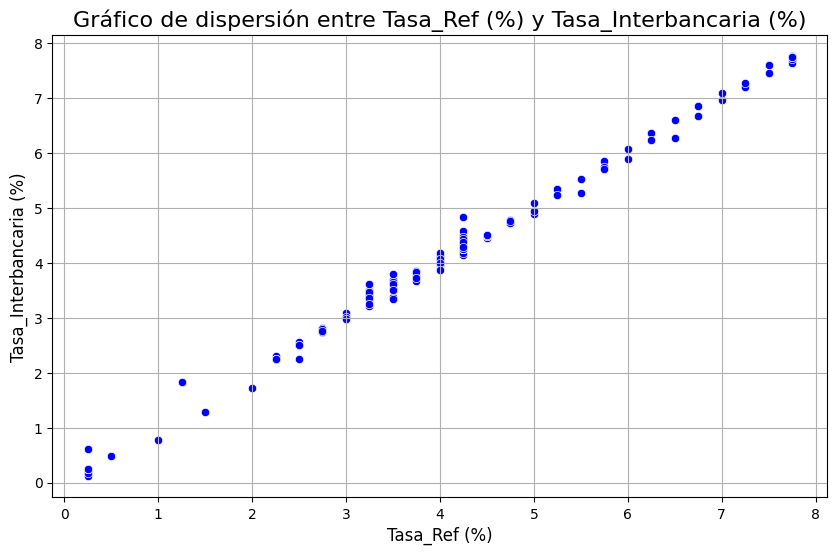

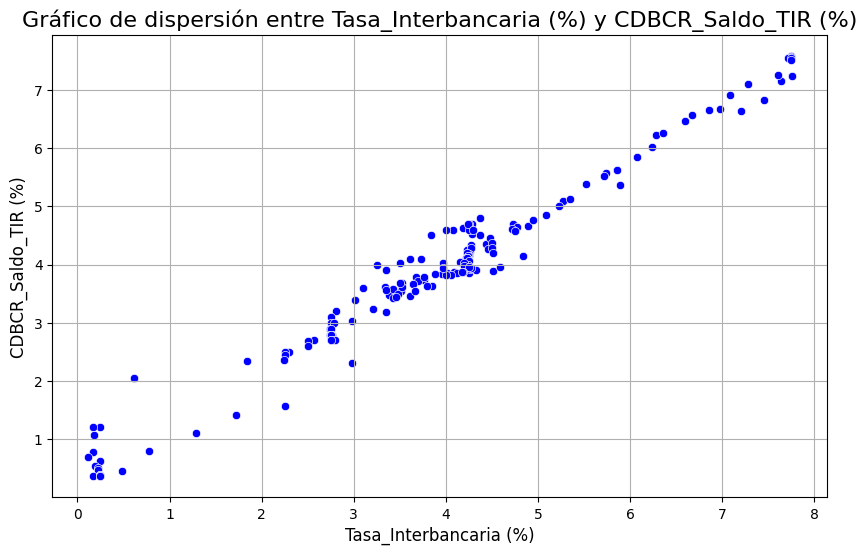

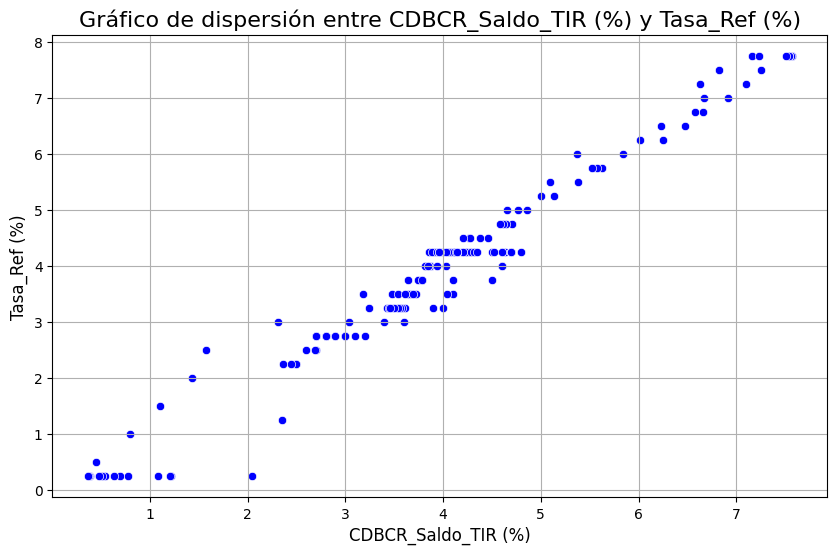

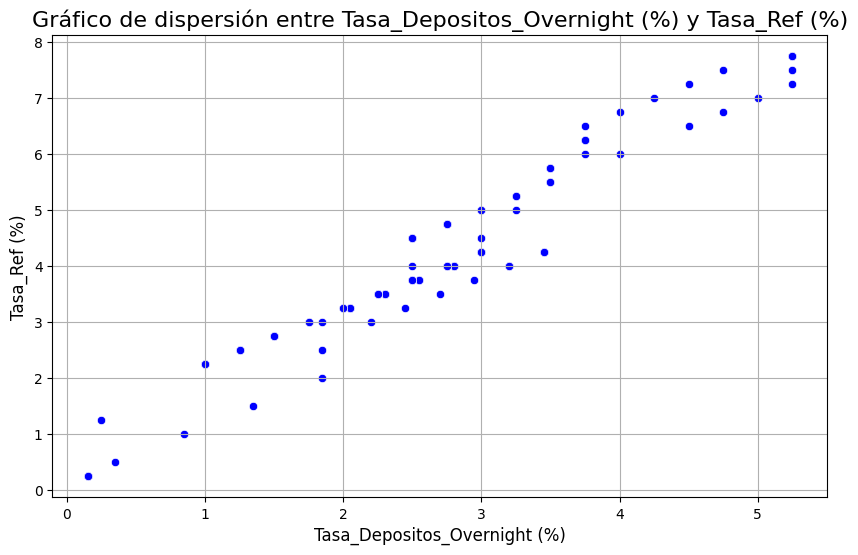

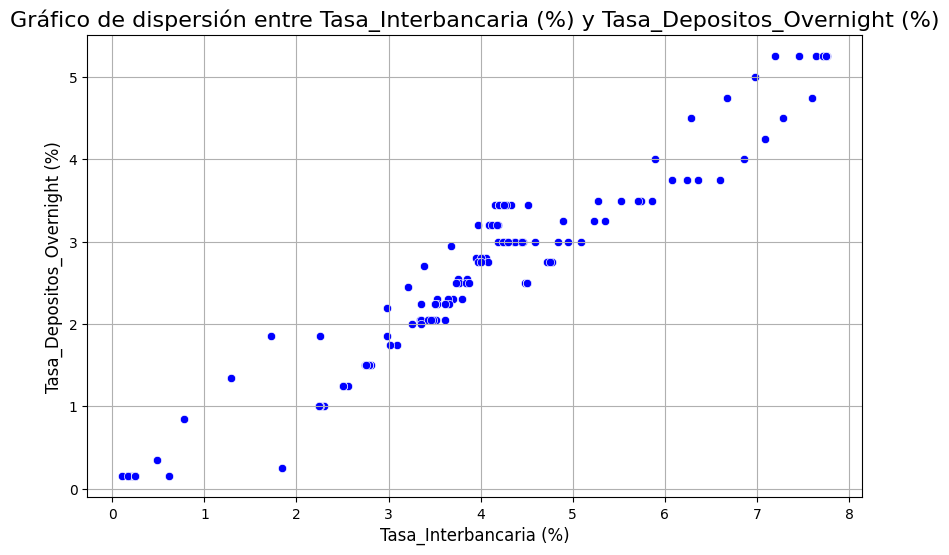

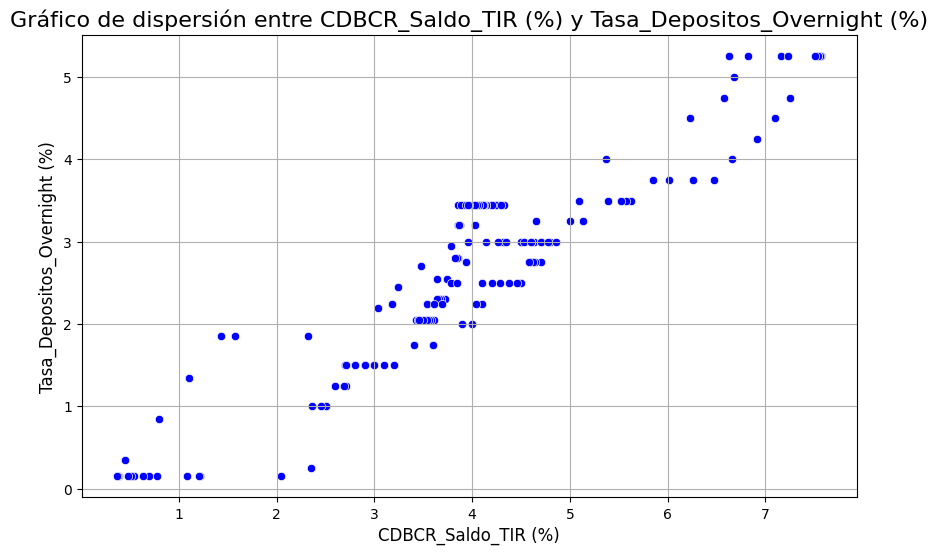

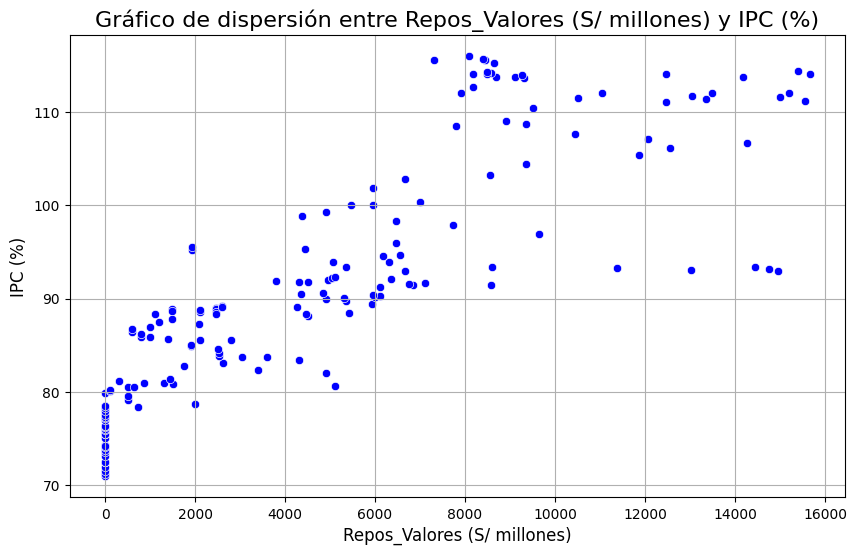

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráficos de dispersión para los pares con correlaciones más altas
pares_correlacionados = [
    ('Tasa_Ref (%)', 'Tasa_Interbancaria (%)'),
    ('Tasa_Interbancaria (%)', 'CDBCR_Saldo_TIR (%)'),
    ('CDBCR_Saldo_TIR (%)', 'Tasa_Ref (%)'),
    ('Tasa_Depositos_Overnight (%)', 'Tasa_Ref (%)'),
    ('Tasa_Interbancaria (%)', 'Tasa_Depositos_Overnight (%)'),
    ('CDBCR_Saldo_TIR (%)','Tasa_Depositos_Overnight (%)'),
    ('Repos_Valores (S/ millones)', 'IPC (%)')
]

# Crear gráficos de dispersión para cada par
for var1, var2 in pares_correlacionados:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_bcrp[var1], y=df_bcrp[var2], color='blue')
    plt.title(f'Gráfico de dispersión entre {var1} y {var2}', fontsize=16)
    plt.xlabel(var1, fontsize=12)
    plt.ylabel(var2, fontsize=12)
    plt.grid(True)
    plt.show()


**Interpretación:**

Los gráficos de dispersión entre las tasas de interés (Tasa_Ref, Tasa_Depositos_Overnight, Tasa_Interbancaria) y el IPC (%) muestran una relación positiva. Esto se puede ver en la forma en que los puntos tienden a agruparse en una línea ascendente: a medida que los valores de las tasas de interés suben, el IPC también tiende a aumentar. Esto podría parecer contradictorio, ya que el objetivo de subir las tasas es controlar la inflación. Sin embargo, este comportamiento se debe a que el BCRP es un agente reactivo. Es decir, las tasas se suben después de que el IPC ya ha empezado a subir, en un intento por contrarrestar la inflación.

En el gráfico que compara el IPC (%) con los Saldos de los Repos de Valores (S/ millones), se aprecia una correlación positiva fuerte. Esto sugiere que, a medida que la inflación aumenta, el volumen de operaciones de reposiciones de valores también lo hace. Esto podría ser el resultado de un mayor uso de estos instrumentos por parte del BCRP para gestionar la liquidez en el mercado en respuesta a las presiones inflacionarias.

En cuanto a la relación entre la Tasa de Referencia y el saldo de CDBR_Total_Saldo, el gráfico muestra una correlación negativa. A medida que la Tasa de Referencia aumenta, el saldo de los CDBR disminuye. Esto es lógico, ya que cuando las tasas de interés suben, los bancos pueden preferir invertir en otros instrumentos más rentables en lugar de mantener sus fondos en el BCRP a través de estos Certificados.